In [1]:
using Pkg
Pkg.activate("C:/Users/conno/Documents/CAMBRIDGE/Part III/Comp Project/JULIA/PROJECT")

# Packages
using Statistics, StatsBase, Distributions, Roots, PyPlot, LsqFit, Combinatorics, FFTW #BlockBootstrap, PyPlot, LsqFit, ProgressMeter, StatsBase, FourierTools, 

using Colors, PlotUtils

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`


In [2]:
function jetmap(N)
    c = cgrad(:jet);
    return (N==1) ? [(red(c[1]), green(c[1]), blue(c[1]))] : [(red(c[i]), green(c[i]), blue(c[i])) for i in range(0,1,length=N)]
end

jetmap (generic function with 1 method)

In [3]:
mutable struct Cell
    σ::Bool # false = +1, true = -1
    D::Float64 # demon energy in units of δE
    x::Array{Float64} # coords
    ∂::Array{UInt32} # boundary
    δ::Array{UInt32} # coboundary
end

In [4]:
function CreateCell(Vs0, Es0, I, X)
    Vs = deepcopy(Vs0)
    Es = deepcopy(Es0)
    
    for v in Vs
        v.x += X
        v.δ .+= length(Es)*(I-1)
    end
    for e in Es
        e.∂ .+= length(Vs)*(I-1)
    end
    
    return Vs, Es
end

CreateCell (generic function with 1 method)

In [5]:
function LatticeGrid(L, PBC, Basis)
    
    Vs0, Es0, Bonds = Basis
    nv = length(Vs0)
    ne = length(Es0)
    
    @assert length(L)==length(PBC)
    dim = length(L)
    
    N = prod(L) # number of unit cells
    
    vertices = [Cell(false, 0, [], [], []) for j in 1:nv*N] # list of vertices
    edges = [Cell(false, 0, [], [], []) for α in 1:ne*N] # list of edges
    
    # define indexing convention
    function X_to_I(X, L)
        I = X[1]
        for d in 2:length(L)
            I += prod(L[1:d-1]) * (X[d]-1)
        end
        return I
    end

    function I_to_X(I, L)
        X = zeros(Int, length(L))
        J = I
        for d in 1:length(L)
            J, X[d] = divrem(J-1,L[d]) .+ (1,1)
        end
        return X
    end

    
    # place down all unit cells without connecting dangling edges
    for I in 1:N
        X = I_to_X(I, L)
        Vs, Es = CreateCell(Vs0, Es0, I, X)
        
        vertices[nv*(I-1)+1:nv*I] .= Vs
        edges[ne*(I-1)+1:ne*I] .= Es
    end
        
    # go back through and link up dangling edges vertices and edges arrays
    for I in 1:N
        X = I_to_X(I, L)
        
        # attach edges (in +ve quadrant)
        for Bond in Bonds
            dir = Bond[2] # relative displacement of linked cell, each a vector ∈ {0,±1}
            ev = Bond[1] # tuple of the edge and the vertex to be linked (within a unit cell)
            
            ifLink = true
            for d in 1:dim # if at a boundary and OBCs then don't link up the edge
                if dir[d]<0 && X[d]==1 && !PBC[d]
                    ifLink = false
                elseif dir[d]>0 && X[d]==L[d] && !PBC[d]
                    ifLink = false
                end
            end
            
            if ifLink
                Y = copy(X)
                for d in 1:dim
                    Y[d] = (dir[d]<0 && X[d]==1) ? L[d] : ((dir[d]>0 && X[d]==L[d]) ? 1 : X[d]+dir[d])
                end
                J = X_to_I(Y, L)
                
                #print(I, " ", J, "\n")
                push!(edges[ev[1]+ne*(I-1)].∂, ev[2]+nv*(J-1))
                push!(vertices[ev[2]+nv*(J-1)].δ, ev[1]+ne*(I-1))
            end
        end
    end
    
    # if there are any remaining dangling edges, they must be on an OBC => kill them
    if !all(PBC)
        toKill = []
        shifts = zeros(length(edges))
        for α in eachindex(edges)
            if length(edges[α].∂) < 2
                push!(toKill, α)
                shifts[α:end] .-= 1
            end
        end
        
        deleteat!(edges, toKill)

        # fix the edges in the coboundary of each vertex
        for v in vertices
            toKillv = []
            for i in eachindex(v.δ)
                if v.δ[i] in toKill
                    push!(toKillv, i)
                end
                v.δ[i] += shifts[v.δ[i]]
            end
            deleteat!(v.δ, toKillv)
        end
    end
    
    # calculate edge positions from vertex positions
    for e in edges
        e.x = zeros(length(L))
        for i in e.∂
            e.x += vertices[i].x
        end
        e.x ./= length(e.∂)
    end
    
    return vertices, edges
end

LatticeGrid (generic function with 1 method)

In [6]:
function CubicBasis(dim)
    Nv = 1
    Ne = dim
    
    Vs = [Cell(false, 0, [], [], []) for j in 1:Nv]
    Es = [Cell(false, 0, [], [], []) for α in 1:Ne]
    
    Vs[1].x = zeros(dim)
    
    Bev = []
    for d in 1:dim
        push!(Es[d].∂, 1)
        push!(Vs[1].δ, d)
        dir = zeros(dim)
        dir[d] = 1
        push!(Bev, [(d, 1), dir])
    end
    
    return (Vs, Es, Bev)
end

CubicBasis (generic function with 1 method)

In [7]:
function SquareSublatticeBasis()
    Nv = 2
    Ne = 12
    
    Vs = [Cell(false, 0, [], [], []) for j in 1:Nv]
    Es = [Cell(false, 0, [], [], []) for α in 1:Ne]
    
    Vs[1].x = [0, 0]
    Vs[2].x = [0.5, 0.5]
    
    tmp = [(1, 1), (2, 1), (3, 1), (4, 1), (2, 2), (3, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2)] # list of links (edge then vertex)
    
    for t in tmp
        push!(Es[t[1]].∂, t[2])
        push!(Vs[t[2]].δ, t[1])
    end
    
    Bev = [[(1, 1), [1 0]], [(4, 1), [0 1]], [(5, 1), [1 0]], [(6, 1), [1 0]], [(7, 2), [1 0]], [(8, 1), [1 1]], [(9, 1), [1 1]], [(10, 2), [0 1]], [(11, 1), [0 1]], [(12, 1), [0 1]]] # dangling edge -> matching vertex
    
    return Vs, Es, Bev
end

SquareSublatticeBasis (generic function with 1 method)

In [8]:
CubicGrid = (L, PBC) -> LatticeGrid(L, PBC, CubicBasis(length(L)))

#17 (generic function with 1 method)

In [9]:
function PlotGraph(vertices, edges) # plot the graph - NOTE will only nicely plot graphs embeddable into R^2 (i.e. won't show PBCs wel!)
    figure()
    for e in edges
        if length(e.∂) > 0
            r1 = vertices[e.∂[1]].x
            r2 = vertices[e.∂[2]].x
            
            plot([r1[1]; r2[1]], [r1[2]; r2[2]], color=(e.σ ? :red : :blue), zorder=1)
        end
    end
    
    #for v in vertices
    #   scatter(v.x[1], v.x[2], color=:black, zorder=2) # color=(A(edges,v)<0 ? :yellow : :black)  
    #end
end

PlotGraph (generic function with 1 method)

In [10]:
function RemoveEdges(vertices, edges, αs)
    
    for α in αs # for each edge α
        verticesToKill = []
        for i in edges[α].∂ # for each vertex connected to α...

            deleteat!(vertices[i].δ ,findfirst(vertices[i].δ .== α)) # remove α from its coboundary
            push!(verticesToKill, i)
        end

        edges[α].∂ = [] # set boundary of α to 0
    end
    
    # Note we don't actually delete any edges, just disconnect them, because we don't want to mess up the indexing
end

RemoveEdges (generic function with 1 method)

# ACTUAL TEST - RANDOM WALK ON GRAPH!!

In [11]:
function CentralIndex(vertices, L)
    xmid = L./2
    
    imin = 1
    dmin = prod(L)
    for i in eachindex(vertices)
        twoNorm = 0
        for d in 1:length(L)
            twoNorm += (vertices[i].x[d] - xmid[d])^2
        end
        
        if twoNorm < dmin
            dmin = twoNorm
            imin = i
        end
    end
    
    return imin
end

CentralIndex (generic function with 1 method)

In [12]:
function PossibleHops(vertices, edges, p, Ps, collisions)
    possibleHops = []
    
    for α in vertices[p].δ
        q = edges[α].∂[findfirst(edges[α].∂ .!= p)]

        if collisions
            # prevents 2x occupancy
            if !(q in Ps)
                push!(possibleHops, q)
            end
        else
            # allows 2x occupancy
            push!(possibleHops, q)
        end
    end
    
    return possibleHops
end

PossibleHops (generic function with 1 method)

In [13]:
function walk(vertices, edges, P, T, L, collisions, doubleHop)
    @assert P < length(vertices)
    D = length(vertices[1].x)
    
    Ptrace = zeros(Int, (P, T))
    Xtrace = zeros(Float64, (D, P, T))
    dXtrace = zeros(Float64, (D, P, T-1))
    
    
    Ptrace[:,1] .= sample(eachindex(vertices), P; replace=true) # random start points
    #Ptrace[:,1] .= sample(eachindex(vertices), P; replace=false) # random non-repeated start points
    
    for t in 1:T-1
        Ptrace[:,t+1] .= deepcopy(Ptrace[:,t])
        
        for n in 1:P
            p = Ptrace[n,t+1]

            hops = PossibleHops(vertices, edges, p, Ptrace[:,t+1], collisions) # possible vertices to hop to

            if length(hops) == 0 # if no possible hops, move on
                continue
            end
            
            
            if doubleHop
                # for each first hop, compile all possible second hops
                secondHops = []
                for q in hops
                    Ptrace[n,t+1] = q # try this first hop
                    secondHops_q = PossibleHops(vertices, edges, p, Ptrace[:,t+1], collisions) # compute possible second hops

                    append!(secondHops, secondHops_q)

                    Ptrace[n,t+1] = p # undo this first hop
                end
                
                deleteat!(secondHops, findall(secondHops .== p)) # can't double-back!
                
                if length(secondHops) == 0 # if no possible double-hops, move on
                    continue
                end
                
                pnext = rand(secondHops)
            else
                pnext = rand(hops)
            end
            
            Ptrace[n,t+1] = pnext # perform the hop
        end
    end
    
    for t in 1:T
        for n in 1:P
            Xtrace[:,n,t] .= vertices[Ptrace[n,t]].x
            
            if t<T
                dXtrace[:,n,t] = vertices[Ptrace[n,t+1]].x .- vertices[Ptrace[n,t]].x

                for d in 1:length(dXtrace[:,n,t]) # correct for PBCs
                    dXtrace[d,n,t] /= (abs(dXtrace[d,n,t])>1) ? -dXtrace[d,n,t] : 1
                end
            end
        end
    end
    
    return Ptrace, Xtrace, dXtrace
end

walk (generic function with 1 method)

In [14]:
function MyAutocor(y, normalise=true) # shamelessly stolen from the StatsBase package - had to b/c of package issues on the TCM network
    T = length(y)
    lags = range(0,T-1)
    
    r = zeros(length(lags))
    for t = eachindex(lags)  # for each lag value
        r[t] = sum(y[1:T-lags[t]] .* y[1+lags[t]:T])
        r[t] /= T - lags[t]
    end
    
    if normalise
        r ./= r[1]
    end
    
    return r
end

MyAutocor (generic function with 2 methods)

In [15]:
# https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft
function Msd_fft(x)
    T = length(x) # number of timesteps
    
    # calculate S1
    D = x.^2
    S1 = zeros(Float64, T)
    Q = 2*sum(D)
    for t in 0:T-1
        D1 = (t==0) ? 0 : D[t]
        D2 = (t==0) ? 0 : D[T-t+1]
        Q -= D1 + D2
        S1[t+1] = Q / (T-t)
    end
    
    # calculate S2
    S2 = MyAutocor(reshape(x, (1, T)), false)

    return S1 .- 2*S2
end

Msd_fft (generic function with 1 method)

In [16]:
function Msd_ez(x)
    lags = range(0, length(x)-1)
    msd = zeros(length(x))    
    
    for (i, lag) in enumerate(lags)
        diffs = x[1:end-lag] .- x[lag+1:end]
        msd[i] += mean(diffs.^2)
    end
    
    return msd
end

Msd_ez (generic function with 1 method)

In [17]:
function Msd(x)
    D = size(x, 1)
    P = size(x, 2)
    T = size(x, 3)
    
    msd = zeros(T)
    for d in 1:D
        for p in 1:P
            msd .+= Msd_fft(x[d,p,:])
        end
    end
    msd ./= P
    
    return msd
end

Msd (generic function with 1 method)

In [18]:
function DirrCorr(dx)
    D = size(dx, 1)
    P = size(dx, 2)
    T = size(dx, 3)
    
    corr = zeros(T)
    for d in 1:D
        for p in 1:P
            corr .+= MyAutocor(dx[d,p,:], false)
        end
    end
     corr ./= P  # average over prtcls, sum over dimensions
    
    return corr
end

DirrCorr (generic function with 1 method)

In [19]:
L = [25, 25]
PBC = [false, false]


P = 5
T = 20

20

In [20]:
vertices, edges = CubicGrid(L, PBC)

toKill = rand(eachindex(edges), floor(Int64, 0.2*length(edges)))
RemoveEdges(vertices, edges, toKill)

#PlotGraph(vertices, edges)

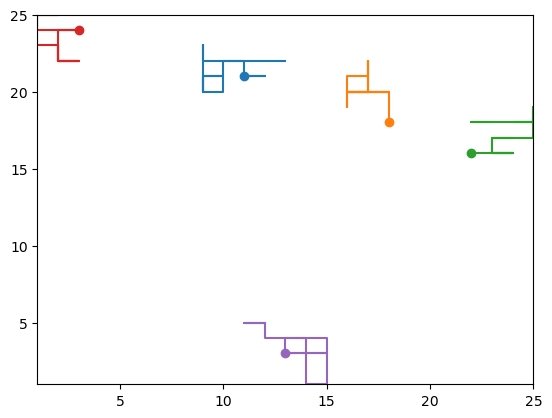

(1.0, 25.0)

In [21]:
_, x, _ = walk(vertices, edges, P, T, L, false, true);

for p in 1:P
    plot(x[1,p,:], x[2,p,:]) 
    scatter(x[1,p,1], x[2,p,1])
end

xlim([1, L[1]])
ylim([1, L[2]])

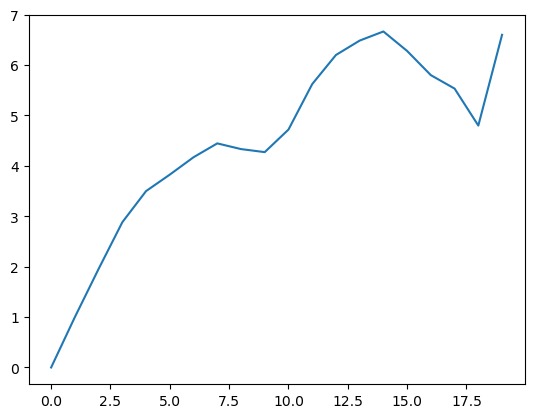

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000021F4A60>

In [22]:
r = Msd(x);
plot(r)

In [23]:
tau = floor(Int64, 0.5*T)
p1 = [0.0, 1.0]

t = collect(range(0,T-1))
xfit = log.(t[2:tau])
yfit = log.(r[2:tau])

fun = (t, p) -> p[1] .+ p[2] .* t
fit = curve_fit(fun, xfit, yfit, p1);

Est = fit.param
Cov = estimate_covar(fit)

print("D = ", exp(Est[1]), ", α = ", Est[2])

D = 1.193461853759928, α = 0.669529557190494

#### Note NO DIVIDING BY $z=2d=4$ in $D$ since we're measuring in units of $\delta t = 1 = 4\delta t_M$

In [24]:
L = [32, 32]
PBC = [true, true]

H = 250 # number of independent histories
P = 250 # number of particles
T = 1000 # simulation time (in units of δt_M = δt/4!!)
tau = 3:100

t = collect(range(0,T-1))

vertices, edges = CubicGrid(L, PBC);

#toRemove = sample(eachindex(edges), floor(Int64, 3*length(edges)/4); replace=false)
#RemoveEdges(vertices, edges, toRemove)

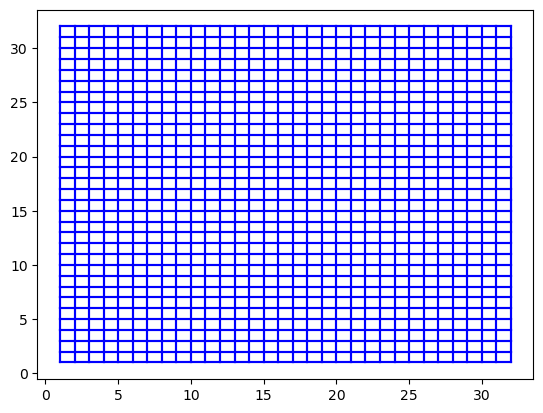

In [25]:
PlotGraph(vertices, edges)

In [26]:
i, x, dx = walk(vertices, edges, P, 100, L, false, false);

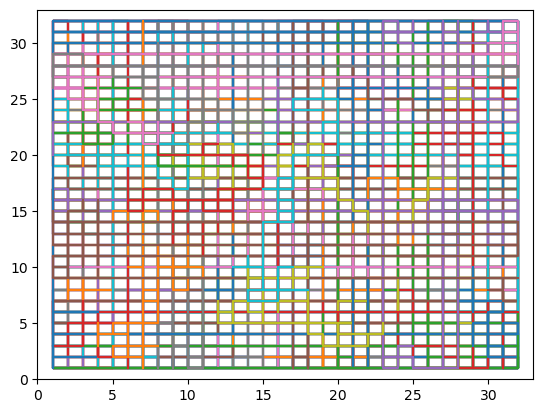

(0.0, 33.0)

In [27]:
for p in 1:P
    plot(x[1,p,:], x[2,p,:])
end
xlim([0,L[1]+1])
ylim([0,L[2]+1])

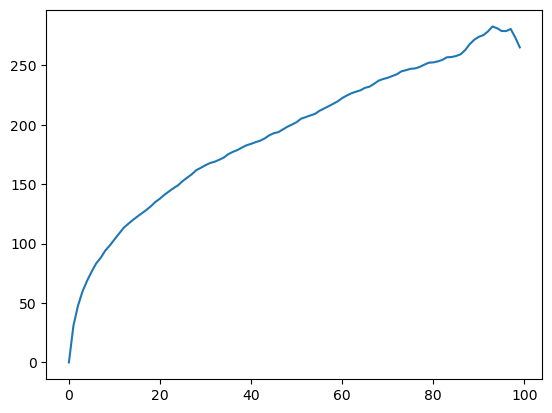

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000E23E9090>

In [28]:
plot(Msd(x))

## Percolation!!

In [29]:
L = [64, 64]
PBC = [false, false]

H = 10 # number of independent histories
P = 10 # number of particles
T = 200 # simulation time (in units of δt_M = δt/4!!)
tau = 3:100

t = collect(range(0,T-1))

percolation = range(0.0, 1.0, length=50)


r = zeros(H, length(percolation), T)
v = zeros(H, length(percolation), T-1)

colors = jetmap(length(percolation))

for h in 1:H
    vertices, edges = CubicGrid(L, PBC) # LatticeGrid(L, PBC, SquareSublatticeBasis()) # 
    originalNumEdges = length(edges)
    numRemoved = 0
    
    for (n, p) in enumerate(percolation)
        numToRemove = floor(Int64, p*originalNumEdges) - numRemoved
        toRemove = sample(eachindex(edges), numToRemove; replace=false)
        RemoveEdges(vertices, edges, toRemove)
        numRemoved += numToRemove
        
        i, x, dx = walk(vertices, edges, P, T, L, false, false);
        r[h,n,:] = Msd(x);
        v[h,n,:] = DirrCorr(dx);
    end
end

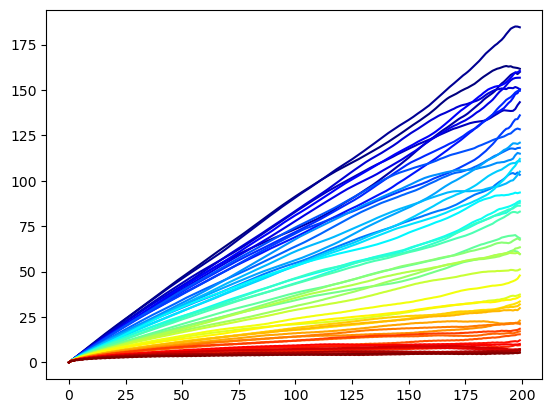

In [30]:
for n in eachindex(percolation)
    plot(t, mean(r[:,n,:], dims=1)', color=colors[n])
end

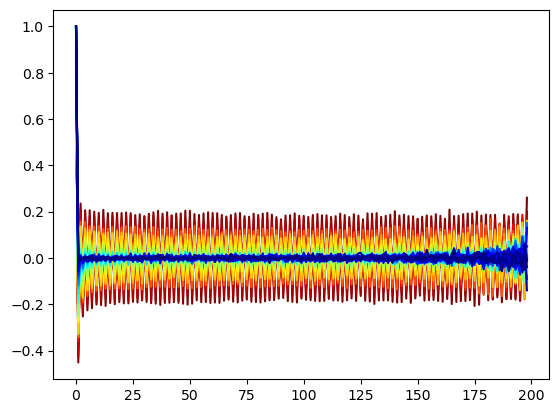

In [31]:
for n in reverse(eachindex(percolation))
    plot(t[1:end-1], mean(v[:,n,:], dims=1)', color=colors[n])
end

In [32]:
fun = (x, p) -> p[1] .* x .^ p[2]
p1 = [2*1.0, 1.0] # initial guess
p2 = [1*1.0, 1.0] # initial guess ~> A=1 and γ=0, i.e. Brownian motion

xfit  = [[] for n in eachindex(percolation)]
yfit1  = [[] for n in eachindex(percolation)]
yfit2  = [[] for n in eachindex(percolation)]
for n in eachindex(percolation)
    for h in 1:H
        append!(xfit[n], t[tau])
        append!(yfit1[n], r[h,n,tau])
        append!(yfit2[n], v[h,n,tau])
    end
end

D = zeros(2, length(percolation))
α = zeros(2, length(percolation))
#A = zeros(2, length(percolation))
#γ = zeros(2, length(percolation))
for (n, p) in enumerate(percolation)
    
    # MSD data
    try
        fit = curve_fit(fun, xfit[n], yfit1[n], p1);

        Est = fit.param
        Cov = estimate_covar(fit)

        D[:,n] = [Est[1], sqrt(Cov[1,1])]
        α[:,n] = [Est[2], sqrt(Cov[2,2])]
    
    catch e
        print(e, "\n")
        D[:,n] = [NaN, NaN]
        α[:,n] = [NaN, NaN]
    end
        
    
    # DirrCorr data
    #try 
    #    yfit2 = log.(v[n,tau])
    #    fit2 = curve_fit(fun, xfit, yfit2, p2);
    #
    #    Est2 = fit2.param
    #    Cov2 = estimate_covar(fit2)
    #
    #    A[:,n] = Est2[1]
    #    γ[:,n] = Est2[2]
    #catch e
    #    print("\n Fit failed at percolation ", p)
    #    A[:,n] = [NaN, NaN]
    #    γ[:,n] = [NaN, NaN]
    #end
end

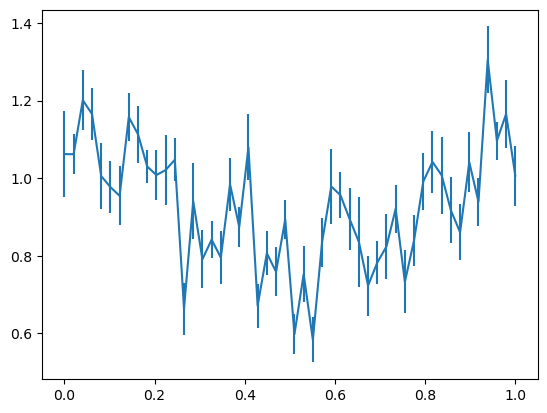

(PyObject <matplotlib.lines.Line2D object at 0x00000000E233DD50>, (), (PyObject <matplotlib.collections.LineCollection object at 0x00000000E233D870>,))

In [33]:
errorbar(percolation, D[1,:], yerr=D[2,:])

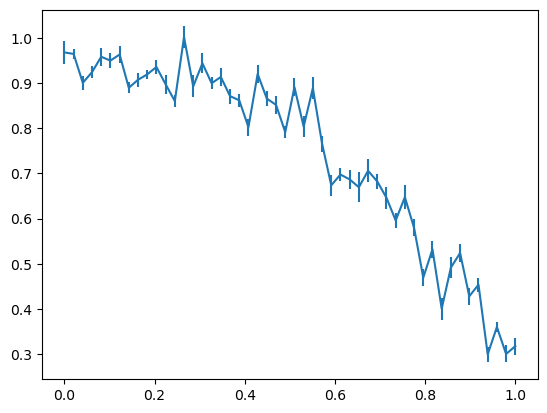

(PyObject <matplotlib.lines.Line2D object at 0x00000000E2525000>, (), (PyObject <matplotlib.collections.LineCollection object at 0x00000000E2525630>,))

In [34]:
errorbar(percolation, α[1,:], yerr=α[2,:])

##### Should get that the volume cluster of size L goes like L^91/48 at p=pc=1/2

#### Fit Check!

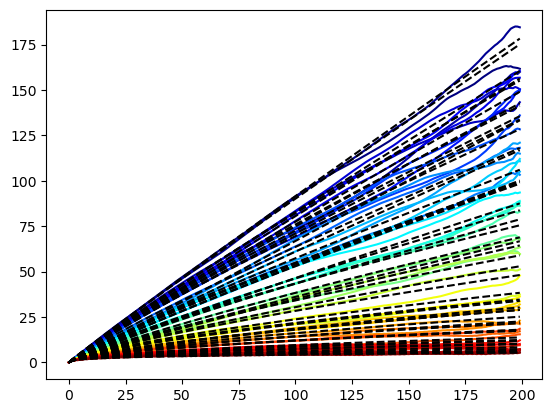

In [35]:
ns = eachindex(percolation)

for n in ns
    plot(t, mean(r[:,n,:], dims=1)', color=colors[n])
end

for n in ns
    plot(t, D[1,n].*t.^α[1,n], color=:black, "--")
end

## Connection between percolation and mean field?

In [32]:
i1 = findall(percolation .>= 1/3) # SINGLE percolation

P1 = percolation[i1]

D1 = D[1,i1]

α1 = α[1,i1]

M1 = sqrt.((3 .* P1 .- 1) ./ 3);

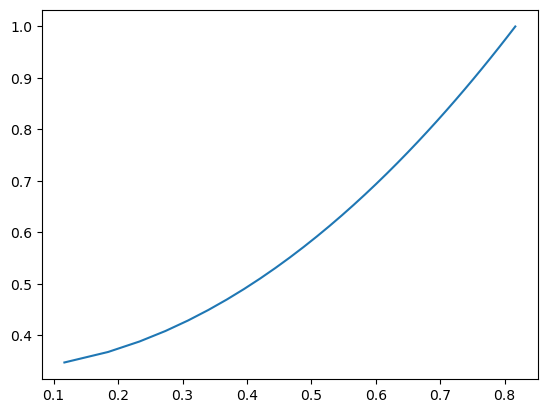

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000EB776D10>

In [33]:
plot(M1, P1)

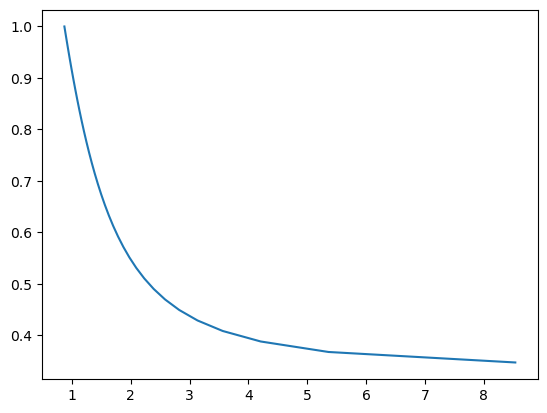

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000EDEDDF60>

In [34]:
plot(1 ./ atanh.(M1), P1)

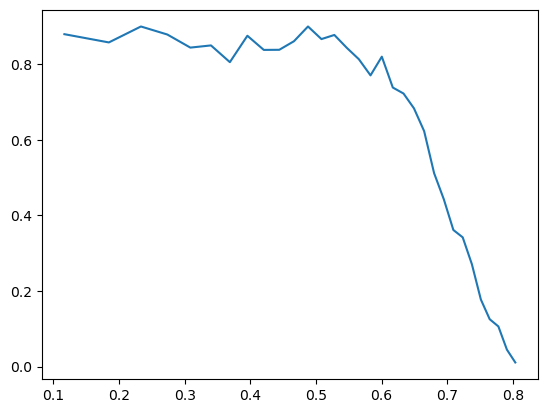

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000EDF75090>

In [35]:
plot(M1, D1)

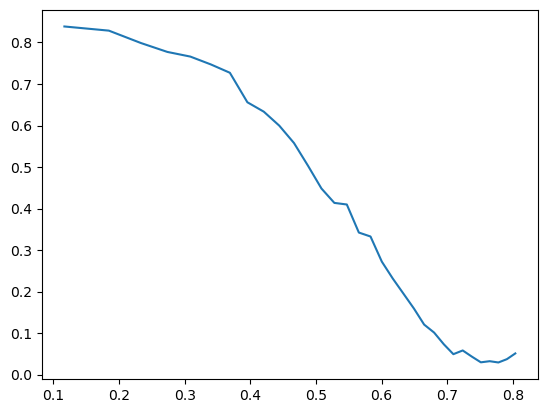

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000EB86F4C0>

In [36]:
plot(M1, α1)

In [37]:
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M) 

hs = range(0, 2, length=7)
colors = jetmap(length(hs));

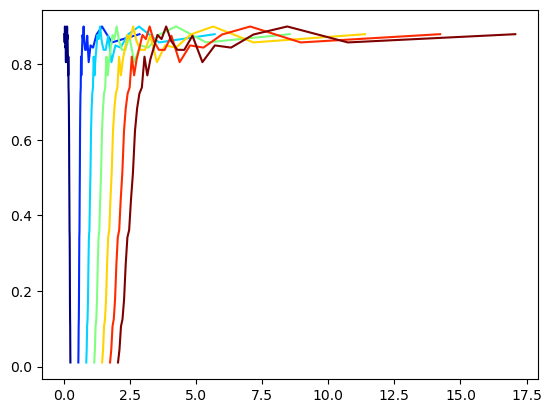

In [38]:
for (i,h) in enumerate(hs)
    plot(Tfun.(M1, h), D1, color=colors[i])
end

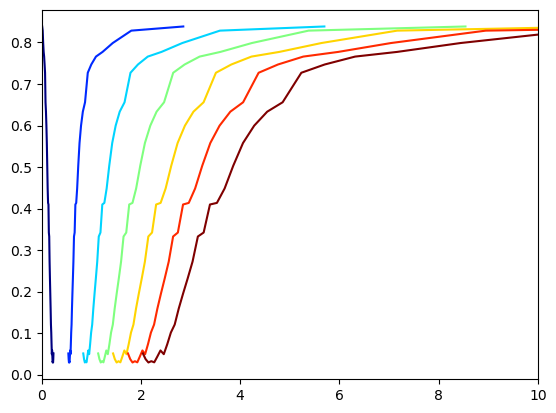

(0.0, 10.0)

In [39]:
for (i,h) in enumerate(hs)
    plot(Tfun.(M1, h), α1, color=colors[i])
end
xlim([0,10])